In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
import sys 
sys.path.insert(0, '../src/')

import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time
import galhalo
import anaclass
import mcmc_aux

dividing your sample into 30 sets
chose ID 12 as the random sample to use as the real data!


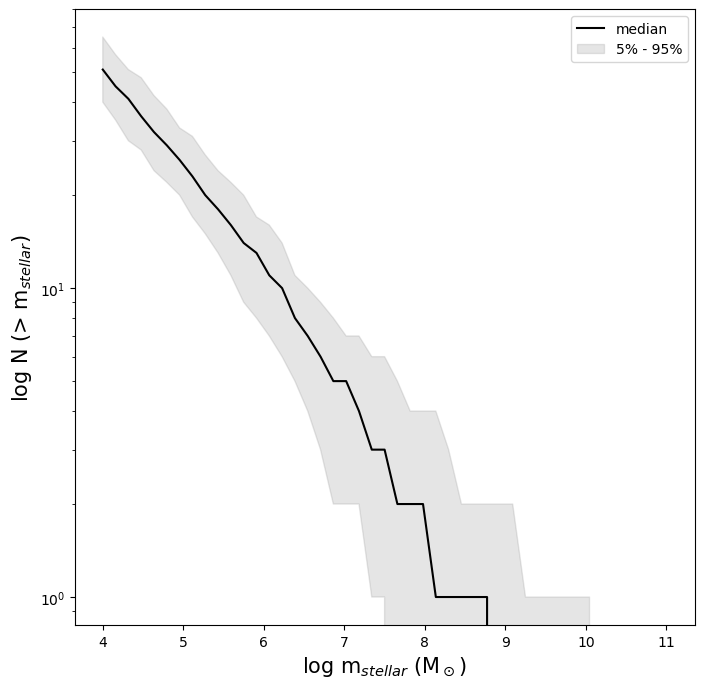

In [5]:
data = mcmc_aux.prep_run("../../data/3000_12_8/", Nsamp=100)

data.create_SAGA_samples(pick=12)

data.plot_real_data()

In [ ]:
def MCMC_RUN(theta_0, lnprob, nwalkers=100, niter=1000, ndim=3, ncores=8, converge=False):

    p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
    
    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        start = time.time()
        sampler.run_mcmc(p0, niter)
        end = time.time()
        multi_time = end - start
        print("Run took {0:.1f} seconds".format(multi_time))

    if converge==True:
        tau = sampler.get_autocorr_time()
        print('$\\alpha$ took', tau[0], 'steps')
        print('$\\delta$ took', tau[1], 'steps')
        print('$\\sigma$ took', tau[2], 'steps')

    return sampler

In [ ]:
#rand = np.random.choice(range(29), 29, replace=False) # no duplicates!
rand = np.random.randint(29,size=3)

In [ ]:
rand

In [ ]:
vals = []
for i in rand:

    data.initialize(i, chi_dim=15)
    print("------------------------------------------------------------------------------------------------------------")
    print("SAGA ID:", i)
    print("------------------------------------------------------------------------------------------------------------")

    def MODEL(theta):    
        alpha, delta, sigma = theta
        lgMs_2D = galhalo.SHMR(data.lgMh, alpha, delta, sigma) # will be a 3D array if sigma is non zero
        counts = np.apply_along_axis(anaclass.cumulative, 1, lgMs_2D)
        quant = np.percentile(counts, np.array([16, 50, 84]), axis=0, method="closest_observation") # median and scatter
        mass_ind = anaclass.find_nearest([6.5, 7, 7.5])
        model = [] # counts at the mass indicies
        for i in mass_ind:
            model.append(quant[2, i])
            model.append(quant[1, i])
            model.append(quant[0, i])
        return np.array(model)
    
    def lnlike(theta):
        model = MODEL(theta)
        X = model - data.D
        X_vec = np.expand_dims(X, axis=1)
        chisquare = X_vec.transpose().dot(data.inv_covar).dot(X_vec)
        return -1/2*chisquare

    def lnprior(theta):
        alpha, delta, sigma = theta
        if 0.5 < alpha < 3.5 and -0.5 < delta < 3.5 and 0 < sigma < 4:
            return 0.0
        return -np.inf

    def lnprob(theta):
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(theta)
    
    MCMC_i = MCMC_RUN(data.theta_0, lnprob)

    run = mcmc_aux.inspect_run(MCMC_i, fid_theta=data.fid_theta)

    #run.chain_plot()
    run.corner_plot()
    run.SHMR_plot()
    #run.chi_square_plot()
    val_i = run.best_fit_values()
    vals.append(val_i)


In [6]:
hmm = np.load("../../data/final_results.npy")

rand = np.arange(29)

In [7]:
hmm.shape

(29, 3, 3)

In [8]:
fid_theta=[1.85, 0.2, 0.3]

In [9]:
alphas = hmm[:,0,0]
a_up = hmm[:,0,1]
a_down = hmm[:,0,2]

deltas = hmm[:,1,0]
d_up = hmm[:,1,1]
d_down = hmm[:,1,2]

sigmas = hmm[:,2,0]
s_up = hmm[:,2,1]
s_down = hmm[:,2,2]

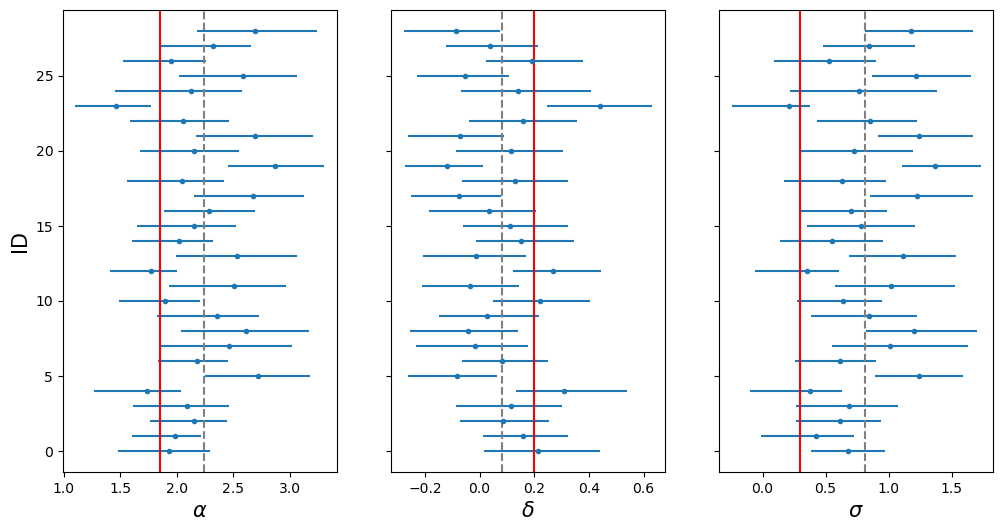

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(12,6))

ax1.errorbar(alphas, rand, xerr=[a_down, a_up], fmt=".")
ax1.axvline(np.average(alphas), color="grey", ls="--")
ax1.axvline(fid_theta[0], color="red")
ax1.set_xlabel('$\\alpha$', fontsize=15)

ax2.errorbar(deltas, rand, xerr=[d_down, d_up], fmt=".")
ax2.axvline(np.average(deltas), color="grey", ls="--")
ax2.axvline(fid_theta[1], color="red")
ax2.set_xlabel('$\\delta$', fontsize=15)

ax3.errorbar(sigmas, rand, xerr=[s_down, s_up], fmt=".")
ax3.axvline(np.average(sigmas), color="grey", ls="--")
ax3.axvline(fid_theta[2], color="red")
ax3.set_xlabel('$\\sigma$', fontsize=15)
ax1.set_ylabel("ID", fontsize=15)
plt.show()


In [ ]:
['$\\alpha$','$\\delta$','$\\sigma$']